In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df_train = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")

In [3]:
X_train, Y_train = df_train.drop(columns="Survived"), df_train["Survived"]

## Exploration des données 

Comparaison des jeux de données 

In [4]:
print(X_train.shape)
print(X_test.shape)

(891, 11)
(418, 11)


In [5]:
X_train.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
X_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

J'ai 3 colonnes qui contiennent des NAN, il va falloir que je les remplace

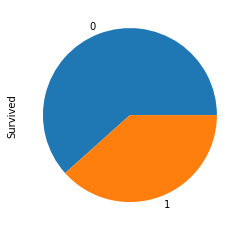

In [7]:
Y_train.value_counts().plot(kind="pie")

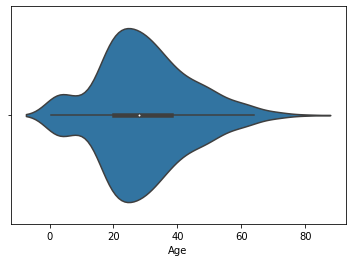

In [8]:
sns.violinplot(X_train["Age"])

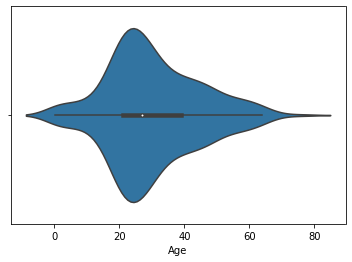

In [9]:
sns.violinplot(X_test["Age"])

Visiblement la distribution des Ages est assez identique entre les deux jeux de données

## Preprocessing

On supprime les colonnes pas intéressantes

In [10]:
def drop_columns(df, columns_to_drop):
    for column in columns_to_drop:
        df.drop(columns=[column], axis=1, inplace=True)
    return df
    

In [11]:
columns_to_drop = ["Name", "Ticket", "Cabin"]
X_train = drop_columns(X_train, columns_to_drop)
X_test =  drop_columns(X_test, columns_to_drop)

On numérise les données 

In [12]:
def get_dummies_df(df, columns_to_dummies):
    for column in columns_to_dummies:
        if column in df.columns:
            _df = pd.get_dummies(df[column])
            df = pd.concat([df, _df], axis=1, sort=False)
            df.drop(columns=[column], inplace=True)
    return df

In [13]:
columns_to_dummies = ["Sex", "Embarked"]
X_train = get_dummies_df(X_train, columns_to_dummies)
X_test =  get_dummies_df(X_test, columns_to_dummies)

remplacer les valeurs NAN pour les deux datasets:

In [14]:
def replace_nan(df, Nan_columns):
    for column in Nan_columns:
        if column in df.columns:
            df[Nan_columns] = df[Nan_columns].fillna(df[Nan_columns].mean())
    return df

In [15]:
Nan_columns = ["Age", "Fare"]
X_train = replace_nan(X_train, Nan_columns)
X_test =  replace_nan(X_test, Nan_columns)

On standardize les données

In [16]:
# from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
# def standardize_df(df, method):
#     columns = df.columns
#     x = df.values 
#     x_scaled = method.fit_transform(x)
#     df = pd.DataFrame(x_scaled)
#     df.columns = columns
#     return df

In [17]:
# scaler = StandardScaler()
# X_train = standardize_df(X_train, scaler)
# X_test =  standardize_df(X_test, scaler)

# Model

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Prédictions

In [20]:
y_pred = clf.predict(X_test)

In [24]:
df_final = pd.DataFrame()

In [25]:
df_final["PassengerId"] = X_test["PassengerId"]
df_final["Survived"] = y_pred

In [27]:
df_final.to_csv("results.csv", index=False, sep=",")

In [29]:
df_demo = pd.read_csv("data/train.csv")

In [35]:
df_demo["Cabin"].astype(str).str[0:2]

0      na
1      C8
2      na
3      C1
4      na
       ..
886    na
887    B4
888    na
889    C1
890    na
Name: Cabin, Length: 891, dtype: object

In [42]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
import numpy as np
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min


In [ ]:
rf_random.best_params_